In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import h5py
import urllib.request
import numpy as np
import pickle as pk
from IPython.display import Image, display, clear_output

In [3]:
from keras.models import Sequential, load_model
from keras.utils.data_utils import get_file
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.utils.data_utils import get_file
from tensorflow.keras.utils import load_img

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array

In [5]:
model1 = VGG16(weights = 'imagenet')
model2 = load_model('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/ft_model.h5')
model3 = load_model('/content/drive/MyDrive/DS_Project/Dataset/car-damage-dataset/data2a/ft_model.h5')
model4 = load_model('/content/drive/MyDrive/DS_Project/Dataset/car-damage-dataset/data3a/ft_model.h5')

553467096/553467096 [==============================] - 3s 0us/step


In [6]:
with open('/content/drive/MyDrive/DS_Project/vgg16_cat_list.pk', 'rb') as f:
    cat_list = pk.load(f)

In [7]:
#Pipe 1: Check for car

CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [8]:
def prepare_image_224(img_path):
    urllib.request.urlretrieve(img_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [9]:
def pipe1(img_224, model):
    print("Ensuring entered picture is a car...")
    out = model.predict(img_224)
    preds = get_predictions(out, top=5)
    for pred in preds[0]:
        if pred[0:2] in cat_list:
            return True #"Successful. Proceeding to damage assessment..."
    return False #"The entered image is a not a car. Please try again. Consider a different angle or lighting."

In [10]:
#Pipe 2: Check for Damage

def prepare_img_256(img_path):
    urllib.request.urlretrieve(img_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    return x

In [11]:
def pipe2(img_256, model):
    print("Validating that damage exists....")
    pred = model.predict(img_256)
    if(pred[0][0]<=0.5):
        return True #print("Validation complete - proceed to location and severity determination")
    else:
        return False
        #print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        #print ("Hint: Try zooming in/out, using a different angle or different lighting")    

In [12]:
def pipe3_loc(img_256, model):
    print("Determining location of damage...")
    pred = model.predict(img_256)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'front', 1:'rear', 2:'side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Result: damage to {} of vehicle".format(d[key]))
    print("Location assessment complete.")

In [13]:
def pipe3_sev(img_256, model):
    print("Determining severity of damage...")
    pred = model.predict(img_256)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'minor', 1:'moderate', 2:'severe'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Result:{} damage".format(d[key]))
    print("Severity assessment complete.")

In [14]:
#Complete Pipeline

def pipeline(img_path): 
    while True:
        #print("Submit image link (or type 'exit' to quit)") 
        #img_path = input("Upload Image File Here:") 
        #if img_path == 'exit': 
        #    return None 
        #clear_output()   
        img_224 = prepare_image_224(img_path) 
        p1 = pipe1(img_224, model1) 
        display(Image('save.jpg', width=300))  
        if p1 is False:
            print("The entered image is a not a car. Please try again. Consider a different angle or lighting.") 
            break 
        else: 
            print("Successful. Proceeding to damage assessment...") 

        img_256 = prepare_img_256(img_path) 
        p2 = pipe2(img_256, model2) 
        
        if p2 is False: 
            print ("Are you sure that your car is damaged? Please submit another picture of the damage.") 
            print ("Hint: Try zooming in/out, using a different angle or different lighting")       
            break 
        else: 
            print("Validation complete - proceed to location and severity determination") 
        
        x = pipe3_loc(img_256, model3) 
        y = pipe3_sev(img_256, model4)
        break 

Ensuring entered picture is a car...
1/1 [==============================] - 1s 537ms/step


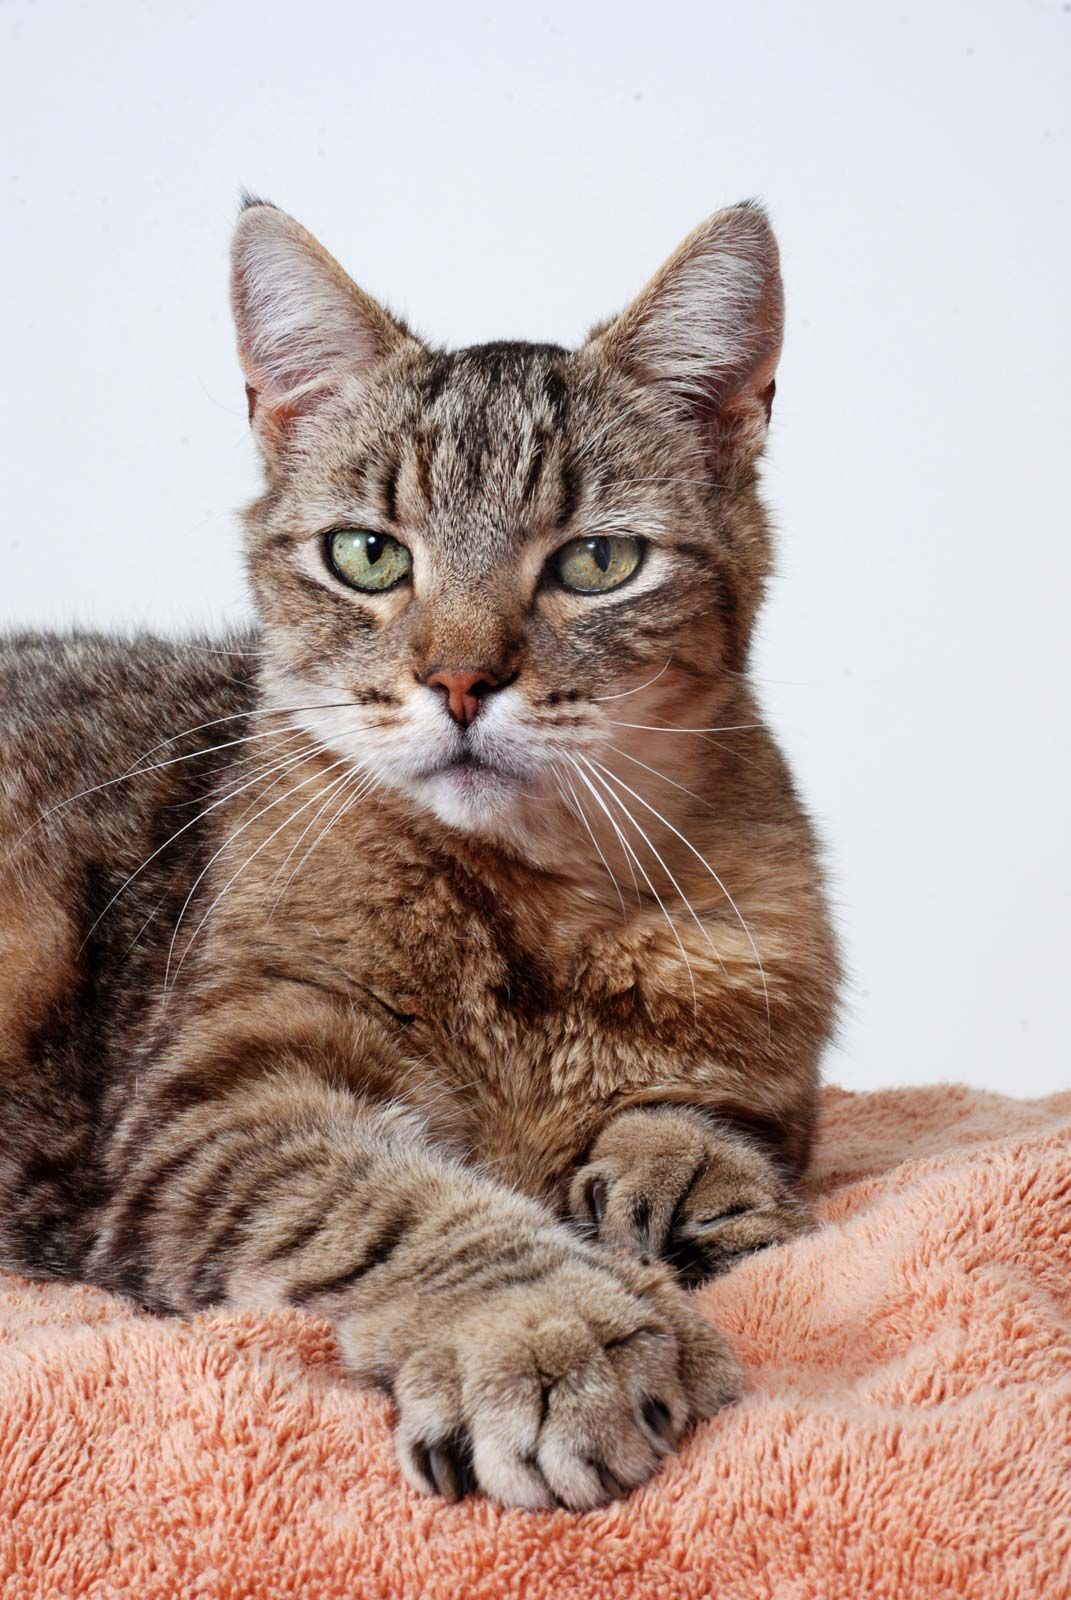

The entered image is a not a car. Please try again. Consider a different angle or lighting.


In [18]:
#pipeline('https://thumbs.dreamstime.com/z/accident-damaged-vehicle-4413106.jpg')
pipeline('https://cdn.britannica.com/91/181391-050-1DA18304/cat-toes-paw-number-paws-tiger-tabby.jpg')